In [1317]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import *
from datetime import datetime
from gensim.test.utils import common_texts, get_tmpfile
import multiprocessing
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
import logging
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gensim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Noelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/miniconda3/envs/py366/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['e', 'datetime', 'seed']
`%matplotlib` prevents importing * from pylab and numpy



In [1279]:
tweets_user = pd.read_csv('./final_project_ironhack/output/User_Noelia/@mrogati_tweets.csv')

In [1280]:
tweets_user.head()

,id,created_at,text
0,1157316313624133632,2019-08-02 15:44:45,"@dweekly @adamnash Clearly, ‘mango seed’ — slo..."
1,1156437458474549249,2019-07-31 05:32:30,Data engineering trends (by @criccomini):\n\nT...
2,1156434561376509952,2019-07-31 05:20:59,@peteskomoroch @hunterwalk Yes! I mentioned it...
3,1156428422400233473,2019-07-31 04:56:35,@criccomini @dpatil @peteskomoroch @msamuelson...
4,1154592365241221121,2019-07-26 03:20:45,RT @mlpowered: 13 months. 250 pages. I wrote a...


In [1281]:
tweet_text = tweets_user[['text']]

In [1282]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [1283]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [1284]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [1285]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [1286]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [1287]:
tweets_user.head()

,id,created_at,text,RT,mention,hashtag
0,1157316313624133632,2019-08-02 15:44:45,"@dweekly @adamnash Clearly, ‘mango seed’ — slo...",0,"dweekly, adamnash",
1,1156437458474549249,2019-07-31 05:32:30,Data engineering trends (by @criccomini):\n\nT...,0,criccomini,
2,1156434561376509952,2019-07-31 05:20:59,@peteskomoroch @hunterwalk Yes! I mentioned it...,0,"peteskomoroch, hunterwalk",
3,1156428422400233473,2019-07-31 04:56:35,@criccomini @dpatil @peteskomoroch @msamuelson...,0,"criccomini, dpatil, peteskomoroch, msamuelson",
4,1154592365241221121,2019-07-26 03:20:45,RT @mlpowered: 13 months. 250 pages. I wrote a...,1,"mlpowered, WWRo",


In [1288]:
def remove_characters(input_text):
    list_remove = ["RT", "(?<![@\w])@(\w{1,25})", "\#+\w+"]
    for charac in list_remove:
        input_text = re.sub(charac, '', input_text)
    return input_text.lower()
def remove_special_characters(data, colum):
    input_text = data[colum].str.replace("[\d\W_]+", " ", re.UNICODE)
    return input_text
def deEmojify(inputString):
    return inputString.encode('latin-1', 'ignore').decode('latin-1')

In [1289]:
def removeSpace(x):
        return " ".join([w for w in x.split() if len(w)>3])
    

In [1290]:
tweets_user['cleaned_tweets'] = tweets_user.text.apply(remove_characters)

In [1291]:
tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].str.replace('http\S+|www.\S+', '', case=False)

In [1292]:
tweets_user['cleaned_tweets'] = remove_special_characters(tweets_user, "cleaned_tweets")

In [1293]:
tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].apply(deEmojify)

In [1294]:
tweets_user['cleaned_tweets'] = tweets_user['cleaned_tweets'].apply(removeSpace)

In [1295]:
stopwords_set = set(stopwords.words("english"))
cleaned_tweets = []
for index, row in tweets_user.iterrows():
    words_without_stopwords = [word for word in row.cleaned_tweets.split() if not word in stopwords_set]
    cleaned_tweets.append(' '.join(words_without_stopwords))
tweets_user['cleaned_tweets'] = cleaned_tweets

In [1296]:
tweets_user['date'] = tweets_user['created_at']

In [1297]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [1298]:
#tweets_user = tweets_user.drop(columns=["created_at", "text"])

In [1299]:
#tweets_user = tweets_user[["id", "date", "mention", "hashtag", "RT", "cleaned_tweets"]]

In [1300]:
tweets_user.head()

,id,created_at,text,RT,mention,hashtag,cleaned_tweets,date
0,1157316313624133632,2019-08-02 15:44:45,"@dweekly @adamnash Clearly, ‘mango seed’ — slo...",0,"dweekly, adamnash",,clearly mango seed slow growth needs nurturing...,2019-08-02
1,1156437458474549249,2019-07-31 05:32:30,Data engineering trends (by @criccomini):\n\nT...,0,criccomini,,data engineering trends timeliness batch real ...,2019-07-31
2,1156434561376509952,2019-07-31 05:20:59,@peteskomoroch @hunterwalk Yes! I mentioned it...,0,"peteskomoroch, hunterwalk",,mentioned briefly article like buil,2019-07-31
3,1156428422400233473,2019-07-31 04:56:35,@criccomini @dpatil @peteskomoroch @msamuelson...,0,"criccomini, dpatil, peteskomoroch, msamuelson",,right data projects prioritie,2019-07-31
4,1154592365241221121,2019-07-26 03:20:45,RT @mlpowered: 13 months. 250 pages. I wrote a...,1,"mlpowered, WWRo",,months pages wrote book want learn ship practi...,2019-07-26


In [1301]:
tweets_user.head()

,id,created_at,text,RT,mention,hashtag,cleaned_tweets,date
0,1157316313624133632,2019-08-02 15:44:45,"@dweekly @adamnash Clearly, ‘mango seed’ — slo...",0,"dweekly, adamnash",,clearly mango seed slow growth needs nurturing...,2019-08-02
1,1156437458474549249,2019-07-31 05:32:30,Data engineering trends (by @criccomini):\n\nT...,0,criccomini,,data engineering trends timeliness batch real ...,2019-07-31
2,1156434561376509952,2019-07-31 05:20:59,@peteskomoroch @hunterwalk Yes! I mentioned it...,0,"peteskomoroch, hunterwalk",,mentioned briefly article like buil,2019-07-31
3,1156428422400233473,2019-07-31 04:56:35,@criccomini @dpatil @peteskomoroch @msamuelson...,0,"criccomini, dpatil, peteskomoroch, msamuelson",,right data projects prioritie,2019-07-31
4,1154592365241221121,2019-07-26 03:20:45,RT @mlpowered: 13 months. 250 pages. I wrote a...,1,"mlpowered, WWRo",,months pages wrote book want learn ship practi...,2019-07-26


In [1302]:
tweets_user.hashtag

0                 
1                 
2                 
3                 
4                 
           ...    
2367              
2368      #twitter
2369    #sentiment
2370              
2371              
Name: hashtag, Length: 2372, dtype: object

In [1303]:
def tokenize(s):
    return s.split(" ") 
        

In [1304]:
tweets_user['tokenized'] = tweets_user['cleaned_tweets'].apply(tokenize)

In [1305]:
for e in tweets_user['cleaned_tweets']:
        print(e.split(" "))

['clearly', 'mango', 'seed', 'slow', 'growth', 'needs', 'nurturing', 'juicy', 'payoff', 'works', 'round', 'enter']
['data', 'engineering', 'trends', 'timeliness', 'batch', 'real', 'time', 'connectivity', 'bespoke', 'integrations']
['mentioned', 'briefly', 'article', 'like', 'buil']
['right', 'data', 'projects', 'prioritie']
['months', 'pages', 'wrote', 'book', 'want', 'learn', 'ship', 'practice', 'check', 'includes', 'tips']
['lyft', 'open', 'sourced', 'autonomous', 'driving', 'dataset', 'level', 'self', 'driving', 'fleet', 'human', 'labeled', 'frames']
['awesome', 'books', 'hold', 'online', 'pick', 'bulk', 'ready', 'takes', 'minut']
['bronze', 'details']
['disagree', 'data', 'cloud', 'days']
['much', 'better', 'health', 'plans', 'employers', 'currently']
['video', 'talk', 'product', 'management', 'conference', 'live']
['right', 'wrong', 'much', 'productivity', 'left', 'table']
['recent', 'survey', 'adoption', 'enterprise', 'tools', 'planning', 'incorporate']
['great', 'options', 'data

['tickets', 'left']
['post', 'linkedin', 'files', 'registration', 'statement', 'initial', 'public', 'offering']
['level', 'millennials', 'changing', 'promotion', 'game', 'behold', 'power', 'linkedin', 'data']
['winner', 'super', 'bowl', 'deserves', 'celebrated', 'winner', 'science', 'fair']
['inmaps', 'visualize', 'linkedin', 'network']
['kinect', 'official', 'software', 'coming', 'microsoft', 'report', 'says']
['awesome', 'field', 'similarity', 'coming']
['train', 'wedding', 'station', 'model', 'answered', 'join', 'data', 'team', 'summer']
['researchers', 'locate', 'twitter', 'users', 'miles', 'based', 'regional', 'word', 'topics']
['useful', 'infographic', 'returns', 'year', 'illustrate', 'recency', 'bias']
['interesting', 'adapting', 'scrum', 'managing', 'research', 'group']
['wait', 'point', 'bees', 'representative', 'sample']
['silicon', 'valley']
['congrats', 'carnegie', 'mellon', 'fellows', 'sara', 'kiesler', 'christos', 'faloutsos']
['waze', 'revs', 'crowdsourced', 'driving']
[

In [1306]:
from nltk.stem.snowball import SnowballStemmer 

In [1307]:
stemmer = SnowballStemmer('english')

In [1308]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import PunktSentenceTokenizer

In [1309]:
sentences = []
for raw_sentence in tweets_user['tokenized']:
    if len(raw_sentence) > 0:
        sentences.append(raw_sentence)

In [1310]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))
print(token_count)

The book corpus contains 16,667 tokens
16667


In [1311]:
array_tweets=tweets_user.iloc[:,[5]].as_matrix()

/miniconda3/envs/py366/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [1312]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

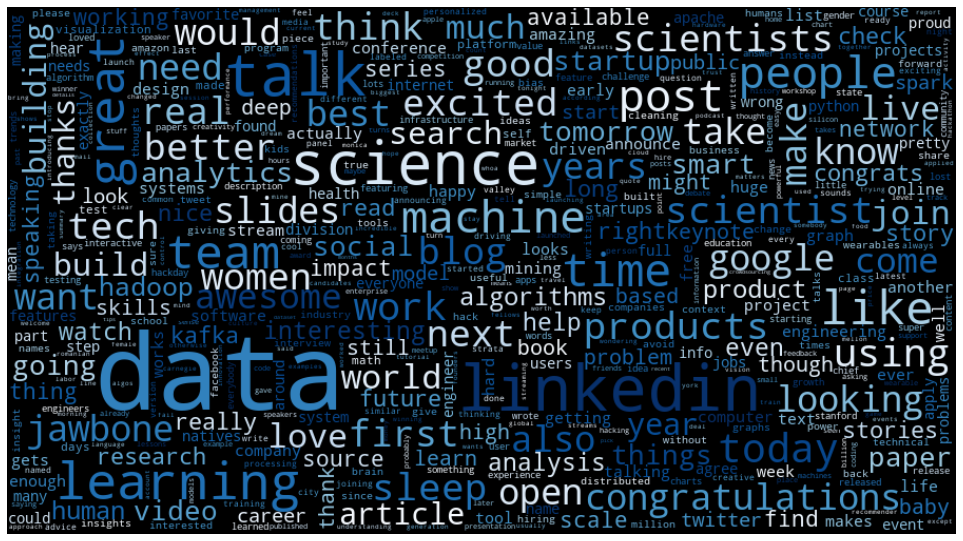

In [1313]:
all_words = []
for line in tweets_user['tokenized']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [1314]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [1315]:
from gensim.models import doc2vec
from collections import namedtuple

In [1316]:
sent

['clearly mango seed slow growth needs nurturing juicy payoff works round enter',
 'data engineering trends timeliness batch real time connectivity bespoke integrations',
 'mentioned briefly article like buil',
 'right data projects prioritie',
 'months pages wrote book want learn ship practice check includes tips',
 'lyft open sourced autonomous driving dataset level self driving fleet human labeled frames',
 'awesome books hold online pick bulk ready takes minut',
 'bronze details',
 'disagree data cloud days',
 'much better health plans employers currently',
 'video talk product management conference live',
 'right wrong much productivity left table',
 'recent survey adoption enterprise tools planning incorporate',
 'great options data warehousing today dozens conversations data teams',
 'selecting features using data splitting folds training testing source train test leakage',
 'excited announce signed agreement join family hear looker',
 'semester complete jupyter notebooks data a

In [1241]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Noelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1242]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [1244]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tweets_user['text']:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [1245]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 40622 items in vocab_frame


In [1246]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=10, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(sent)

print(tfidf_matrix.shape)

/miniconda3/envs/py366/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



CPU times: user 807 ms, sys: 6.39 ms, total: 813 ms
Wall time: 813 ms
(2372, 340)


In [1247]:
terms = tfidf_vectorizer.get_feature_names()

In [1248]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [1261]:
from sklearn.cluster import KMeans

num_clusters = 15

km = KMeans(n_jobs=-1, n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 21.2 ms, sys: 3.52 ms, total: 24.7 ms
Wall time: 497 ms


In [1262]:
tweets = {'tweet': sent,  'cluster': clusters}
frame = pd.DataFrame(tweets, index = [clusters] , columns = ['tweet', 'cluster'])

In [1277]:
frame

,tweet,cluster
0,clearly mango seed slow growth needs nurturing...,0
0,data engineering trends timeliness batch real ...,0
6,mentioned briefly article like buil,6
5,right data projects prioritie,5
0,months pages wrote book want learn ship practi...,0
0,lyft open sourced autonomous driving dataset l...,0
0,awesome books hold online pick bulk ready take...,0
0,bronze details,0
5,disagree data cloud days,5
0,much better health plans employers currently,0


In [1263]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    #print("Cluster %d titles:" % i, end='')
    #for title in frame.ix[i]['title'].values.tolist():
    #    print(' %s,' % title, end='')
    print()

Top terms per cluster:

Cluster 0 words: b'linkedin', b'talk', b'works', b'time', b'make', b'people', b'years', b'thank', b'today', b'great', b'using', b'think', b'women', b'starting', b'tech', b'needs', b'open', b'want', b'looks', b'teams',

Cluster 1 words: b'shirt', b'best', b'years', b'wonderful', b'avoid', b'talk', b'tell', b'like', b'management', b'life', b'debate', b'bringing', b'women', b'valley', b'stanford', b'career', b'actually', b'win', b'amazing', b'many',

Cluster 2 words: b'sleep', b'sleep', b'data', b'nights', b'hour', b'lost', b'cities', b'story', b'women', b'years', b'million', b'jawbone', b'changed', b'tracking', b'lot', b'impact', b'people', b'activation', b'best', b'knows',

Cluster 3 words: b'compared', b'sleep', b'research', b'difference', b'career', b'facebook', b'algorithms', b'apache', b'wearables', b'nights', b'love', b'papers', b'brain', b'speakers', b'help', b'data', b'event', b'better', b'networks', b'features',

Cluster 4 words: b'learn', b'machines', b'

/miniconda3/envs/py366/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



 b'data', b'teams', b'story', b'linkedin', b'build', b'comes', b'algorithms', b'great', b'using', b'analytic', b'cleaning', b'slides', b'insight',

Cluster 6 words: b'like', b'looks', b'looks', b'using', b'sounds', b'works', b'want', b'comes', b'think', b'parents', b'creativity', b'great', b'question', b'early', b'starting', b'technical', b'another', b'turns', b"'smart", b'pretty',

Cluster 7 words: b'congratulations', b'excited', b'huge', b'join', b'teams', b'win', b'awesome', b'amazing', b'time', b'data', b'looks', b'make', b'life', b'love', b'good', b'news', b'innovators', b'award', b'valley', b'list',

Cluster 8 words: b'baby', b'data', b'driven', b'data', b'parents', b'talk', b'chart', b'thank', b'instead', b'features', b'time', b'approaches', b'session', b'build', b'using', b'gender', b'works', b'huge', b'meeting', b'friends',

Cluster 9 words: b'post', b'blog', b'blog', b'data', b'linkedin', b'kafka', b'streaming', b'using', b'real', b'link', b'hired', b'people', b'time', b'work

In [1266]:
from sklearn.metrics import pairwise_distances_argmin_min
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

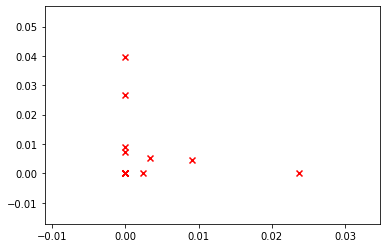

In [1264]:
centers = np.array(km.cluster_centers_)

#This array is one dimensional, thus we plot it using:
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')

In [1275]:
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=25)

/miniconda3/envs/py366/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [1276]:
hdbscan.fit(tfidf_matrix)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=25, min_samples=None, p=None,
        prediction_data=False)

In [1115]:
doc1 = ["This is a sentence", "This is another sentence"]

# Transform data (you can add more data preprocessing steps) 

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(sent):
    words = text.lower().split()
    #print(words)
    tags = [i]
   # print(tags)
    docs.append(analyzedDocument(words, tags))
   # print(docs)
Text_INPUT_DIM=100
# Train model (set min_count = 1, if you want the model to work with the provided example data set)

#model = doc2vec.Doc2Vec(size = 300, window = 300, min_count = 1, workers = 4)
model = doc2vec.Doc2Vec(min_count=5, window=5, size=Text_INPUT_DIM, 
                        sample=1e-4, negative=5, workers=4, iter=5,seed=1)




In [1116]:
model.build_vocab(docs)
 #   text_model.save(filename)

In [1124]:
len(docs)

2372

In [1117]:
model.train(docs, total_examples=model.corpus_count, epochs=model.iter)

/miniconda3/envs/py366/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).



In [1119]:
model.most_similar('science')

/miniconda3/envs/py366/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('answer', 0.3924218714237213),
 ('used', 0.28183647990226746),
 ('insights', 0.24828743934631348),
 ('developher', 0.24104614555835724),
 ('magic', 0.235075905919075),
 ('second', 0.2305522859096527),
 ('computing', 0.23001757264137268),
 ('glad', 0.22260907292366028),
 ('mean', 0.21756704151630402),
 ('sensor', 0.21707051992416382)]

In [1120]:
# Get the vectors
model.docvecs[2300]
#model.docvecs[1]

array([ 3.84886004e-03, -9.76121519e-04,  2.00195820e-03,  1.94832822e-03,
        4.62190743e-04, -4.69926232e-03, -3.19715193e-03,  3.54583608e-03,
       -8.46115989e-04, -4.83941476e-05, -3.75923724e-03, -3.01790098e-03,
       -3.69937136e-03,  4.44133207e-03,  4.88981884e-03, -3.48395464e-04,
       -2.69025168e-03,  2.93068495e-03,  4.09237895e-04,  3.60371405e-03,
        6.55320473e-04, -3.84036405e-03,  2.87747616e-03, -4.93838312e-03,
        4.90677822e-03,  3.27469385e-03, -3.08372849e-03, -5.56864179e-05,
        1.20398682e-03, -3.95420194e-03,  2.04420346e-03, -4.64992336e-04,
        1.76475022e-03,  3.72507982e-03, -1.79775455e-03, -4.90484759e-03,
        1.30386662e-03, -3.42952111e-03, -1.88064890e-03, -8.52537749e-04,
        9.56693955e-04,  1.60082383e-03, -1.21095945e-04,  2.69762333e-03,
       -4.82556701e-04,  9.12626158e-04,  1.28365669e-03, -3.22891749e-03,
       -8.40047549e-04,  1.59784756e-03, -3.55484150e-03, -4.18342697e-03,
       -1.10785430e-03, -

In [1138]:
X=[]
for i in range(40):
    X.append(model.docvecs[i])

In [1121]:
model.vocabulary

In [1026]:
sent = [row for row in tweets_user['cleaned_tweets']]

In [1061]:
tweet_vocab = []
for e in sent:
        tweet_vocab.append(e)

In [1001]:
model = gensim.models.Word2Vec(min_count=2, size=100,window=2,
                     sample=6e-5, 
                     alpha=0.01, 
                     min_alpha=0.0007,negative=20,
                     workers=cores-1
                              )

In [1002]:
#t = time()

model.build_vocab(data_array, progress_per=10000)

#print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [1077]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [1008]:
from sklearn.manifold import TSNE

In [988]:
#tsne_plot(model)

In [1009]:
import umap
from umap import UMAP

In [1140]:
umap = UMAP(n_components=2)
embedding = umap.fit_transform(X)

In [1141]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

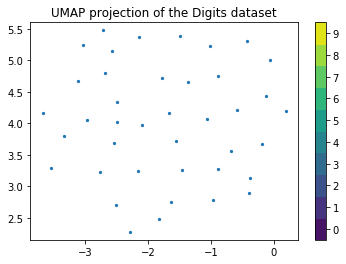

In [1142]:
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=12);

In [1149]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

#print all the labels
print (kmeans.labels_)


[3 0 0 2 1 1 1 2 2 0 3 0 1 1 3 3 3 3 1 1 0 1 0 2 1 3 3 1 3 0 2 0 3 2 0 1 0
 0 1 2]


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [1151]:
plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

TypeError: list indices must be integers or slices, not tuple

In [710]:
from time import time 

In [711]:
t = time()

model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.01 mins


In [722]:
model.wv.most_similar(positive=["engineering"])

[('learning', 0.9997985363006592),
 ('sure', 0.9997684955596924),
 ('blog', 0.9997667074203491),
 ('really', 0.9997621774673462),
 ('social', 0.9997618794441223),
 ('work', 0.9997588396072388),
 ('fellows', 0.9997543692588806),
 ('today', 0.9997530579566956),
 ('data', 0.999752402305603),
 ('great', 0.9997475147247314)]

In [716]:
model.wv.similarity("start", 'data')

0.9998057752085019

In [613]:
word_freq = defaultdict(int)
for sen in sent:
    for e in sen:
        word_freq[e] += 1
len(word_freq)

5173

In [614]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['data',
 'linkedin',
 'talk',
 'science',
 'learning',
 'great',
 'like',
 'team',
 'time',
 'machine']

In [ ]:
corpus = onehot.fit_transform(corpus.toarray())

In [732]:
def tsnescatterplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [733]:
tsnescatterplot(model, sent)

TypeError: unhashable type: 'list'

In [634]:
import multiprocessing

from gensim.models import Word2Vec
cores = multiprocessing.cpu_count() 

In [318]:
from keras.preprocessing.text import Tokenizer

In [319]:
from keras.preprocessing.sequence import pad_sequences

In [320]:
tokenizer_object = Tokenizer()

In [321]:
tokenizer_object.fit_on_texts(tweets_user['cleaned_tweets'])

In [322]:
sequences = tokenizer_object.texts_to_sequences(tweets_user['cleaned_tweets'])
#vectorize  the text samples into 2d integer tensor

In [323]:
#pad sequences
word_index = tokenizer_object.word_index
print('Found {} unique tokens.'. format(len(word_index)))

Found 5673 unique tokens.


In [324]:
labels = []

In [325]:
label_id = len(word_index)

In [326]:
for name, i in word_index.items():
    labels.append(i)

In [327]:
max_length = max([len(s.split()) for s in tweets_user['cleaned_tweets']])

In [328]:
review_pad = pad_sequences(sequences, maxlen = max_length)
print('Shape of tweet tensor is {}'. format(review_pad.shape))

Shape of tweet tensor is (2372, 18)


In [329]:
num_words = len(word_index)+1

In [330]:
embedding_dim=100

In [331]:
embedding_matrix = np.zeros((num_words, embedding_dim))

In [332]:
for word, i in word_index.items():
    if i < num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] =embedding_vector

In [333]:
embedding_vector

array([ 6.61260e-02, -4.04360e-02, -2.74850e-02, -8.66630e-02,
       -8.51030e-02, -4.25080e-02, -2.90670e-02, -4.97430e-02,
        3.99080e-02, -4.71920e-02, -2.44800e-03, -7.54170e-02,
        4.28540e-02, -6.74210e-02,  8.72200e-03, -1.59460e-02,
       -2.27140e-02,  2.50970e-02,  4.72550e-02,  8.93600e-02,
       -5.25780e-02, -1.59000e-04, -1.78890e-02,  2.21140e-02,
        3.57500e-03, -3.18240e-02, -3.90190e-02,  2.61000e-04,
       -4.15070e-02,  9.52100e-03,  1.75670e-02, -2.01760e-02,
        2.06750e-02, -5.19030e-02,  5.59600e-03, -1.05840e-02,
       -5.01270e-02,  1.70330e-02,  2.62170e-02, -1.26390e-02,
        1.65710e-02,  4.40840e-02, -1.12840e-01, -8.86450e-02,
       -3.26530e-02, -3.82230e-02, -7.51040e-02,  2.43990e-02,
        7.35510e-02,  6.08800e-03,  5.03100e-02,  7.57850e-02,
        2.08330e-02,  6.20440e-02, -7.29270e-02,  3.45350e-02,
       -1.76430e-02,  3.17750e-02,  5.14330e-02, -4.85400e-03,
        4.73340e-02,  3.79890e-02, -6.11540e-02,  5.891

In [334]:
print(num_words)

5674


In [719]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform( tweets_user['cleaned_tweets'])
print(vectorizer.get_feature_names())

['aaah', 'abbreviation', 'ability', 'able', 'abnormal', 'abstract', 'abstractions', 'abstracts', 'abuse', 'abusive', 'academia', 'academic', 'academy', 'accel', 'accelerated', 'accelerator', 'accented', 'accepted', 'accepts', 'access', 'accessing', 'accessorize', 'accidental', 'accidentally', 'accomplish', 'according', 'account', 'accumulative', 'accuracy', 'accurate', 'achievement', 'achieving', 'acidity', 'acknowledging', 'acquired', 'acquires', 'acquisition', 'acronyms', 'across', 'action', 'actionable', 'actions', 'activation', 'active', 'activities', 'activity', 'actual', 'actually', 'adapting', 'adapts', 'added', 'adding', 'additional', 'addres', 'address', 'addressed', 'addresses', 'admin', 'administration', 'admired', 'adoption', 'adults', 'advanced', 'advances', 'advantage', 'advantages', 'adventure', 'advertising', 'advice', 'advisers', 'advisor', 'advisors', 'afaik', 'affect', 'affectionately', 'afford', 'afraid', 'afternoon', 'agarwal', 'agencies', 'ages', 'aggravation', 'a

In [720]:
vectorizer.vocabulary_

{'clearly': 772,
 'mango': 2758,
 'seed': 4025,
 'slow': 4213,
 'growth': 2009,
 'needs': 3028,
 'nurturing': 3110,
 'juicy': 2487,
 'payoff': 3292,
 'works': 5113,
 'round': 3906,
 'enter': 1493,
 'data': 1087,
 'engineering': 1482,
 'trends': 4769,
 'timeliness': 4668,
 'batch': 372,
 'real': 3692,
 'time': 4665,
 'connectivity': 920,
 'bespoke': 417,
 'integrations': 2365,
 'mentioned': 2849,
 'briefly': 537,
 'article': 250,
 'like': 2636,
 'buil': 564,
 'right': 3877,
 'projects': 3564,
 'prioritie': 3518,
 'months': 2946,
 'pages': 3227,
 'wrote': 5143,
 'book': 481,
 'want': 5004,
 'learn': 2599,
 'ship': 4107,
 'practice': 3462,
 'check': 711,
 'includes': 2266,
 'tips': 4676,
 'lyft': 2723,
 'open': 3152,
 'sourced': 4278,
 'autonomous': 310,
 'driving': 1360,
 'dataset': 1096,
 'level': 2621,
 'self': 4037,
 'fleet': 1753,
 'human': 2191,
 'labeled': 2550,
 'frames': 1812,
 'awesome': 325,
 'books': 483,
 'hold': 2145,
 'online': 3149,
 'pick': 3350,
 'bulk': 571,
 'ready': 3

In [721]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import Normalizer

In [346]:
vectorizer = HashingVectorizer(n_features=20)
vector = vectorizer.transform(tweets_user['cleaned_tweets'])